# Preprocess

## Import Libraries

In [1]:
!pip install pytorch torchvision cudatoolkit
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers
!pip install opencv-python

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement cudatoolkit (from versions: none)
ERROR: No matching distribution found for cudatoolkit
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-h40zfonw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-h40zfonw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00

In [2]:
import torch
import torch.nn as nn
import clip
import requests
import os
import cv2
import glob
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statistics import mean
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import ToPILImage

mount drive to access the translated captions

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Preprocess Flickr8k Dataset

### define download_and_extract function

In [4]:
def download_and_extract(url, extract_to='.'):
    filename = url.split('/')[-1]
    print(f"Downloading {filename} ...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Extracting {filename} ...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted to {extract_to}")
        os.remove(filename)
    else:
        print(f"Failed to download {url}")

### download dataset and unzip

In [5]:
flickr8k_url = "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"

os.makedirs('datasets/flickr', exist_ok = True)

download_and_extract(flickr8k_url, 'datasets/flickr')

Extracting flickr8k.zip ...
Extracted to datasets/flickr


### Read Captions and save to DataFrame

In [6]:
captions_flickr = []
with open("datasets/flickr/captions.txt", 'r') as file:
    for line in file:
        img_name, caption = line.strip().split(',', 1)
        captions_flickr.append((img_name, caption))
captions_flickr = captions_flickr[1:]

In [7]:
captions = pd.DataFrame(captions_flickr, columns=['image', 'caption_en'])
captions['id'] = range(len(captions))

captions.head()

,image,caption_en,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,1
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,2
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,3
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,4


### Import translated Captions

In [8]:
files_path = '/content/drive/MyDrive/'

fa_captions = []
for i in range(1,7):
    data = pd.read_excel(''.join([files_path, f'flickr8k_translated_captions{i}.xlsx']))
    fa_captions.append(data)

merged_df = pd.concat(fa_captions, axis=0).dropna(subset=['caption_fa'])
merged_df = merged_df.drop_duplicates(subset = ['image','caption_en'])
merged_caps = pd.merge(captions, merged_df, on=['image','caption_en'],how='inner')
merged_caps.head()

,image,caption_en,id,caption_fa
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0,کودکی با لباس صورتی در حال بالا رفتن از مجموعه...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,1,دختری که وارد یک ساختمان چوبی می شود.
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,2,دختر بچه ای در حال بالا رفتن از یک خانه بازی چ...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,3,دختر بچه ای که از پله ها به سمت خانه بازی اش ب...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,4,دختر بچه ای با لباس صورتی که وارد یک کابین چوب...


In [9]:
# Check Validity of Merge

merged_caps.shape, merged_caps['caption_fa'].isna().sum()

((40059, 4), 0)

### Check Translation Validity

In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.9/275.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.3.1
    Uninstalling sentence-transformers-3.3.1:
      Successfully uninstalled sentence-transformers-3.3.1


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [ ]:
# Test model
a = "Dog"
b = 'سگ'
c = [a,b]
emb =  model.encode(c)
oe = emb[0]
te = emb[1]
print(cosine_similarity(oe, te))

0.9715707


In [ ]:
similarities = []

for i, row in tqdm(merged_caps.iterrows()):
    sentences = [row['caption_en'], row['caption_fa']]
    embeddings = model.encode(sentences)
    original_embd = embeddings[0]
    translated_embedding = embeddings[1]
    similarity = cosine_similarity(original_embd, translated_embedding)
    similarities.append(similarity)


40059it [1:31:13,  7.32it/s]


In [ ]:
mean(similarities)

0.7685066

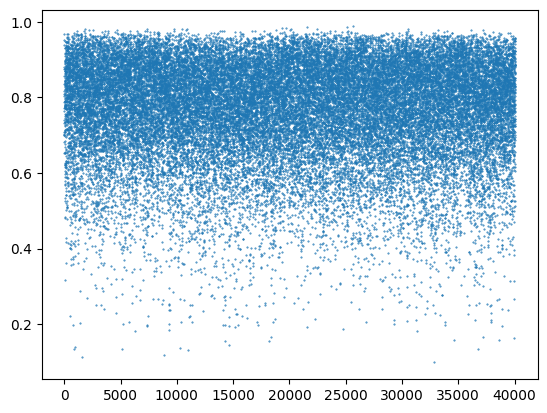

In [ ]:
plt.scatter(range(len(similarities)), similarities, s=0.2)

# Define Model

In [10]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
import os
os.environ['HF_TOKEN'] = # Inser your HF_TOKEN

from huggingface_hub import login
login(token=os.getenv('HF_TOKEN'))

In [54]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define Dataset

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [13]:
class ImageCaptionDataSet(Dataset):
    def __init__(self, dataset, path, processor):
        self.dataset = dataset
        self.processor = processor
        self.image_folder_path = path

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset.iloc[idx]
        caption = item['caption_fa']
        image = Image.open(''.join([self.image_folder_path, item['image']]))
        inputs = self.processor(text=[caption],
                                images=image,
                                return_tensors="pt",
                                padding=True,
                                truncation=True,
                                max_length=77)
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)
        max_text_len = 77
        input_ids_padded = torch.nn.functional.pad(input_ids,
         (0, max_text_len - input_ids.size(0)),
                                                   value=processor.tokenizer.pad_token_id)
        attention_mask_padded = torch.nn.functional.pad(attention_mask, (0, max_text_len - attention_mask.size(0)))
        pixel_values = inputs['pixel_values'].squeeze(0)
        return {
            'input_ids': input_ids_padded,
            'attention_mask': attention_mask_padded,
            'pixel_values': pixel_values
        }

In [14]:
x_train, x_test,y_train, y_test = train_test_split(merged_caps[['caption_fa', 'id']],
                                  merged_caps[['image', 'id']],
                                  random_state=42,
                                  test_size=0.2,
                                  shuffle=True)

path = '/content/datasets/flickr/Images/'

In [15]:
train_dataset = ImageCaptionDataSet(pd.merge(x_train, y_train,on='id',how='inner' ), path, processor)
test_dataset = ImageCaptionDataSet(pd.merge(x_test, y_test, on='id',how='inner'), path, processor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Fine-Tune

## Freeze the vision encoder

In [55]:
for param in model.parameters():
    param.requires_grad = False

for param in model.text_model.embeddings.token_embedding.parameters():
    param.requires_grad = True

In [56]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cuda'

## Define train loop

In [59]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=2, device="cpu"):
    train_loss_list = []
    val_loss_list = []
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_dataloader):
            batch = {key:tensor.to(device) for key, tensor in batch.items()}
            outputs = model(**batch)
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text

            targets = torch.arange(batch["input_ids"].size(0)).to(logits_per_image.device)
            image_loss = loss_fn(logits_per_image, targets)
            text_loss = loss_fn(logits_per_text, targets)
            loss = (text_loss + image_loss) / 2

            optimizer.zero_grad()
            loss.backward()
            train_loss += loss.detach()
            optimizer.step()
        train_loss_list.append(train_loss.item()/ len(train_dataloader))

        model.eval()
        val_loss = 0
        for batch in tqdm(val_dataloader):
            batch = {key:tensor.to(device) for key, tensor in batch.items()}
            outputs = model(**batch)
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text

            targets = torch.arange(batch["input_ids"].size(0)).to(logits_per_image.device)
            image_loss = loss_fn(logits_per_image, targets)
            text_loss = loss_fn(logits_per_text, targets)
            loss = (text_loss + image_loss) / 2
            val_loss += loss.detach()
        val_loss_list.append(val_loss.item()/len(val_dataloader))
        print(f"Epoch : {epoch}, Train Loss : {train_loss / len(train_dataloader)}, Val Loss : {val_loss / len(val_dataloader)}")
    print("Fine-tuning completed!")
    return train_loss_list, val_loss_list

In [57]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

25296896

In [32]:
def save_model(model):
    torch.save(model.state_dict(), "/content/drive/MyDrive/model_parameters.pth")

In [60]:
train_loss1, val_loss1 = train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, 10, device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
train_loss2, val_loss2 = train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, 10, device)
save_model(model)

100%|██████████| 251/251 [01:19<00:00,  3.17it/s]


Epoch : 0, Train Loss : 1.514800786972046, Val Loss : 1.168986201286316


100%|██████████| 251/251 [01:21<00:00,  3.09it/s]


Epoch : 1, Train Loss : 1.0156406164169312, Val Loss : 0.9942389130592346


100%|██████████| 251/251 [01:20<00:00,  3.12it/s]


Epoch : 2, Train Loss : 0.8744527101516724, Val Loss : 0.9102320075035095


100%|██████████| 251/251 [01:20<00:00,  3.13it/s]


Epoch : 3, Train Loss : 0.8053660988807678, Val Loss : 0.9086410999298096


100%|██████████| 251/251 [01:19<00:00,  3.14it/s]


Epoch : 4, Train Loss : 0.7575471997261047, Val Loss : 0.8711743950843811


100%|██████████| 251/251 [01:20<00:00,  3.11it/s]


Epoch : 5, Train Loss : 0.7217136025428772, Val Loss : 0.831041693687439


100%|██████████| 251/251 [01:20<00:00,  3.13it/s]


Epoch : 6, Train Loss : 0.6895952820777893, Val Loss : 0.8535062670707703


100%|██████████| 251/251 [01:21<00:00,  3.09it/s]


Epoch : 7, Train Loss : 0.6784961819648743, Val Loss : 0.8363515138626099


100%|██████████| 251/251 [01:21<00:00,  3.08it/s]


Epoch : 8, Train Loss : 0.6597875952720642, Val Loss : 0.8460572957992554


100%|██████████| 251/251 [01:20<00:00,  3.11it/s]


Epoch : 9, Train Loss : 0.639114260673523, Val Loss : 0.8599422574043274
Fine-tuning completed!


100%|██████████| 251/251 [01:21<00:00,  3.07it/s]


Epoch : 0, Train Loss : 0.4855104088783264, Val Loss : 0.7500327229499817


100%|██████████| 251/251 [01:20<00:00,  3.11it/s]


Epoch : 1, Train Loss : 0.44848349690437317, Val Loss : 0.7335126399993896


100%|██████████| 251/251 [01:20<00:00,  3.10it/s]


Epoch : 2, Train Loss : 0.42714524269104004, Val Loss : 0.734330415725708


100%|██████████| 251/251 [01:20<00:00,  3.12it/s]


Epoch : 3, Train Loss : 0.419907808303833, Val Loss : 0.7301791310310364


100%|██████████| 251/251 [01:19<00:00,  3.15it/s]


Epoch : 4, Train Loss : 0.4004879295825958, Val Loss : 0.7290211915969849


100%|██████████| 251/251 [01:17<00:00,  3.23it/s]


Epoch : 5, Train Loss : 0.40022632479667664, Val Loss : 0.729435384273529


100%|██████████| 251/251 [01:19<00:00,  3.17it/s]


Epoch : 6, Train Loss : 0.38876873254776, Val Loss : 0.7346919775009155


100%|██████████| 251/251 [01:19<00:00,  3.17it/s]


Epoch : 7, Train Loss : 0.38191214203834534, Val Loss : 0.7326369881629944


100%|██████████| 251/251 [01:18<00:00,  3.20it/s]


Epoch : 8, Train Loss : 0.3772426247596741, Val Loss : 0.7451934814453125


100%|██████████| 251/251 [01:18<00:00,  3.19it/s]


Epoch : 9, Train Loss : 0.3738049566745758, Val Loss : 0.7309344410896301
Fine-tuning completed!


In [34]:
save_model(model)

In [ ]:
train_loss = [a.item() for a in train_loss][::10]

In [ ]:
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.legend()
    plt.show()

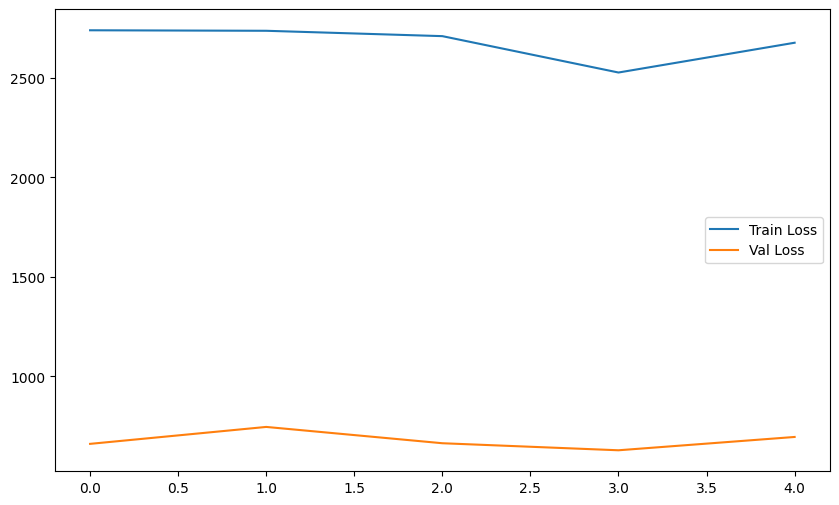

In [ ]:
plot_loss(train_loss, val_loss)

# Import Evaluation Data

## Unzip Videos

In [35]:
!unzip -q '/content/drive/MyDrive/general.zip' -d '/content/'

## Extract frames of each video

In [36]:
def video_frame_extract_get_fps(video_path, frames_dir):
    os.makedirs(frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    step = 1 if fps < 2 else int(fps / 2)
    frame_count = 0
    frame_step = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_filename = os.path.join(frames_dir, f"frame_{frame_count:04d}.jpg")
        frame_step += 1
        if frame_step < step:
            continue

        cv2.imwrite(frame_filename, frame)
        frame_step = 0
        frame_count +=1

    cap.release()

In [37]:
def extract_frames_from_videos(videos_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    video_files = glob.glob(os.path.join(videos_folder, '*.mp4'))

    for video_file in video_files:
        video_name = os.path.splitext(os.path.basename(video_file))[0]
        video_frames_folder = os.path.join(output_folder, video_name)
        os.makedirs(video_frames_folder, exist_ok=True)
        video_frame_extract_get_fps(video_file, video_frames_folder)
    print(f"Extracted frames from {len(video_files)} videos.")

## Encode frames

In [38]:
def encode_frames(frames_dir):
    # List to store encoded frames
    encoded_frames = []

    # Iterate over each frame image
    for frame_file in sorted(os.listdir(frames_dir)):
        if frame_file.endswith('.jpg'):
            frame_path = os.path.join(frames_dir, frame_file)
            image = Image.open(frame_path)

            # Process the image to the required format
            inputs = processor(images=image, return_tensors="pt")

            # Get the pixel values
            pixel_values = inputs['pixel_values'].squeeze(0)  # Remove batch dimension
            encoded_frames.append(pixel_values)

    # Stack the encoded frames into a single tensor
    encoded_frames_tensor = torch.stack(encoded_frames)

    return encoded_frames_tensor

## Save and load tensor arrays

In [39]:
def preprocess_videos(video_folder, output_folder, frame_folder):
    frame_list = []
    extract_frames_from_videos(video_folder, output_folder)
    os.makedirs(frame_folder, exist_ok=True)
    for _, folder in tqdm(enumerate(os.listdir(output_folder))):

        frames = encode_frames(''.join([output_folder, folder]))
        torch.save(frames, f"{frame_folder}{folder}.pt")


In [40]:
def load_frame_tensor(frame_folder):
    frame_array = []
    for frame in sorted(os.listdir(frame_folder)):
        frame_path = ''.join([frame_folder, frame])
        frame_array.append(torch.load(frame_path))
    return torch.concat(frame_array)

In [41]:
video_folder = '/content/general/'
output_folder = '/content/khorogi/'

preprocess_videos(video_folder,output_folder, '/content/frames/')

Extracted frames from 13 videos.


13it [00:24,  1.91s/it]


In [42]:
frames = load_frame_tensor('/content/frames/')

<ipython-input-40-3efd8b52b66c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frame_array.append(torch.load(frame_path))


In [43]:
frames.shape

torch.Size([995, 3, 224, 224])

# Text-To-Image Retrieval

## Text-To-Image Retrieval Function

In [44]:
def text_image_retrieval(model, processor, text, frames_tensor, top_k=5, device="cpu"):
    model = model.to(device)
    model.eval()
    frames_tensor = frames_tensor.to(device)
    text_inputs = processor(text=[text], return_tensors="pt", padding=True,
                            truncation=True, max_length=77).to(device)
    text_features = model.get_text_features(**text_inputs)
    frame_features = model.get_image_features(pixel_values=frames_tensor)

    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    frame_features = frame_features / frame_features.norm(dim=-1, keepdim=True)

    # Similarities
    similarities = torch.matmul(text_features, frame_features.T)

    top_k_indices = similarities.topk(top_k, dim=1).indices.squeeze(0).tolist()

    for i, idx in enumerate(top_k_indices):

        most_similar_frame = frames_tensor[idx].cpu()

        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])

        # Convert the tensor back to a PIL image
        denormalized_pixel_values = most_similar_frame * std[:, None, None] + + mean[:, None, None]
        denormalized_pixel_values = torch.clamp(denormalized_pixel_values, 0, 1)
        image = ToPILImage()(denormalized_pixel_values)

        plt.figure()
        plt.imshow(image)
        plt.title(f"Top {i+1} Similar Frame.")
        plt.axis('off')  # Hide axes for better visualization
    plt.show()

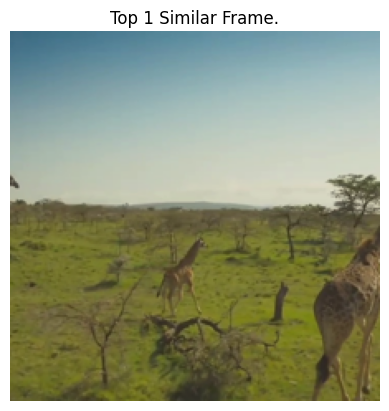

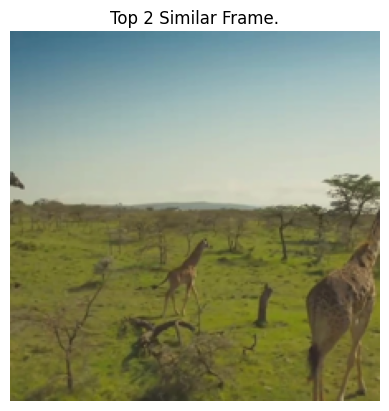

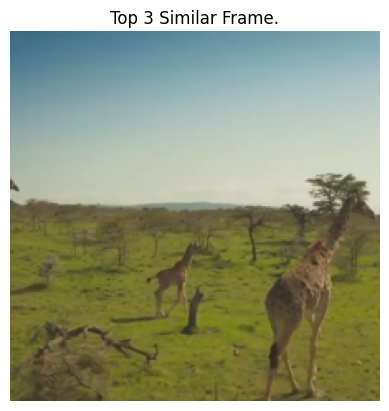

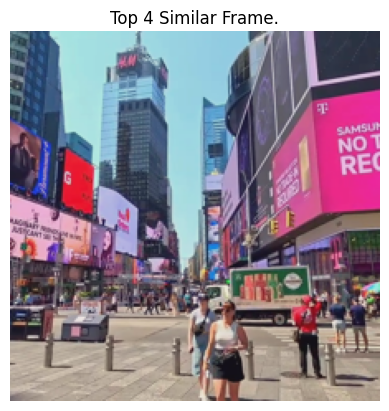

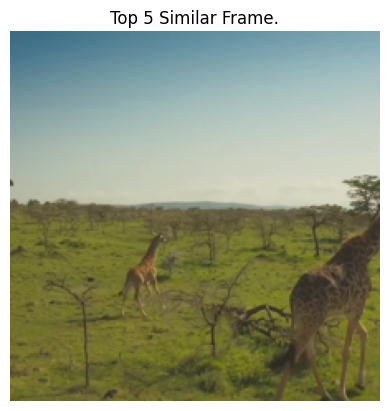

In [64]:
# Test text_image_retrieval function
text_image_retrieval(model, processor, "قدم زدن در کوهستان", frames, device=device)